In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
from matplotlib.ticker import FuncFormatter

In [6]:
pd.set_option('display.max_rows',100)

## Consumption_afterPV mode peakload already reduced from discharge but mode dutycycle not reduced

In [8]:
def predictcon(predict_date):
    num_day=30

    predict_day=int(predict_date[8:])
    predict_month=int(predict_date[5:7])
    predict_year=int(predict_date[0:4])

    str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

    daybefore=[]
    pmb=predict_month-1
    dayleft=num_day-predict_day

    if predict_day>num_day:
        day=predict_day-num_day
        while day<predict_day:
            daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(day).zfill(2))
            day+=1
    else:
        if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
            for i in range(31-dayleft,32,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
            for i in range(30-dayleft,31,1):
                daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
            for i in range(1,predict_day,1):
                daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
        else:
            if predict_year%4==0:
                for i in range(29-dayleft,30,1):
                    daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
                for i in range(1,predict_day,1):
                    daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))
            else:
                for i in range(28-dayleft,29,1):
                    daybefore.append(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(i).zfill(2))
                for i in range(1,predict_day,1):
                    daybefore.append(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(i).zfill(2))

    pathlist=[]
    for i in daybefore:
        pathlist.append('Energy_Balance_'+str(i))

    def clean(path):
        rawdata=pd.read_csv(path+".csv", delimiter=";" )
        deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
        rawdata.drop(deleteindex,inplace=True)
        rawdata.rename(columns={' ':'Time'},inplace=True)
        rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
        rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
        rawdata['Time']=pd.to_datetime(rawdata.Time)
        rawdata.set_index('Time', inplace=True)
        for i in rawdata.columns:
            if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
                rawdata.drop([i],axis=1,inplace=True)
        for i in rawdata.columns:
            rawdata[i].fillna('0',inplace=True)
            rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
            rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
        rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
        rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
        rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
        rawdata.drop(['Generation'],axis=1,inplace=True)
        return rawdata

    rawdata=[]

    for i in pathlist:
        df=clean(i)
        rawdata.append(df)


    data=rawdata[0]
    for i in range(num_day-1):
        data=pd.concat([data,rawdata[i+1]])


    for i in range(data.shape[0]):
        if data.iloc[i,0]==0:
            data.iloc[i,0]=data.iloc[i-96,0]

    fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()

    fit4.fittedvalues.plot(style='--', color='red')

    forecast=fit4.forecast(96)

    params=fit4.model.params
    Consumption=[]
    for i in forecast:
        Consumption.append(i)
    return Consumption


In [9]:
def predictgen(predict_date):
    import os
    import pandas as pd
    import json
    import datetime

    def createDayDataframe(filename):
        path = "tongsdata/"
        filedate = filename.split(".")[0].split("-")

        with open(path + filename, 'r', encoding='utf-8') as fin:
            data_json = json.loads(fin.read())

        #  Create X DataFrame
        todayData = {time: data_json[time]['currently'] for time in data_json}
        todayData_DF = pd.DataFrame(todayData).T

        #  Create y DataFrame
        energyBalanceFilename = "energyBalance/Energy_Balance_{}_{}_{}.csv".format(filedate[0], filedate[1], filedate[2]) #change due to json filename
        energyBalance = pd.read_csv(path + energyBalanceFilename, delimiter=";")

        energyBalance_DF = pd.DataFrame(index=energyBalance.iloc[:-1,0].apply(lambda x: x[2:-1]))
        energyBalance_DF['PV Power Generation'] = energyBalance['PV power generation / Mean values [W]  '].values[:-1]
        energyBalance_DF = energyBalance_DF[energyBalance_DF != ' ']
        energyBalance_DF = energyBalance_DF.dropna()

        #  Join X y DataFrame
        data = todayData_DF.join(energyBalance_DF)
        return data

    def cleanDataframe(masterDF):
        masterData_cleaned = masterDF.reset_index()
        masterData_cleaned = masterData_cleaned.rename(columns={'index': 'time_of_day'})
        masterData_cleaned = masterData_cleaned[masterData_cleaned['PV Power Generation'].notna()]
        masterData_cleaned['month'] = masterData_cleaned['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
        masterData_cleaned['cloudCover'] = masterData_cleaned['cloudCover'].fillna(value=masterData_cleaned['cloudCover'].mean())
        masterData_cleaned['PV Power Generation'] = masterData_cleaned['PV Power Generation'].apply(lambda x: x.replace(",", "")).astype('float')
        return masterData_cleaned

    def featureEngineering(masterDF):
        masterDF = masterDF.drop(columns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure'])
        masterDF = pd.get_dummies(masterDF, columns=['time_of_day', 'precipType', 'uvIndex', 'month']) 
        return masterDF

    files = os.listdir("tongsdata/")

    #files.remove(".DS_Store")
    files.remove("energyBalance")

    masterData = pd.DataFrame()

    for file in files:
        r = createDayDataframe(file).loc['06:30':'18:00']
        print(file, r.shape)
        masterData = pd.concat([masterData, r], axis=0)

    masterData = cleanDataframe(masterData)
    masterData = featureEngineering(masterData)

    features = list(masterData.drop(columns=['PV Power Generation']).columns)

    masterData = masterData.dropna()

    X = masterData.drop(columns=['PV Power Generation']).astype('float').values
    y = masterData['PV Power Generation'].astype('float').values


    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split

    training_features, testing_features, training_target, testing_target = train_test_split(X, y)

    # Average CV score on the training set was:-91867.4890210794
    exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=1, min_samples_split=7, n_estimators=100)

    exported_pipeline.fit(training_features, training_target)
    results = exported_pipeline.predict(testing_features)

    from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
    print(mean_squared_error(testing_target, results), 
    mean_absolute_error(testing_target, results), 
    r2_score(testing_target, results))


    def pvpredict(predict_date) :
        path = "tongsdata/"
        filename = predict_date.replace("_",'-') + '.json'

        with open(path + filename, 'r', encoding='utf-8') as fin:
            data_json = json.loads(fin.read())

        todayData = {time: data_json[time]['currently'] for time in data_json}
        todayData_DF = pd.DataFrame(todayData).T
        todayData_DF.index.names=['time_of_day']
        todayData_DF = todayData_DF.loc['06:30':'18:00']
        todayData_DF = todayData_DF.reset_index()
        todayData_DF['month'] = todayData_DF['time'].apply(datetime.datetime.fromtimestamp).apply(lambda x: x.month)
        todayData_DF['cloudCover'] = todayData_DF['cloudCover'].fillna(value=todayData_DF['cloudCover'].mean())
        dropcolumns=['icon', 'summary', 'time', 'windBearing', 'windGust', 'ozone', 'precipIntensity', 'precipProbability','pressure']
        for i in dropcolumns:
            if i in todayData_DF.columns:
                todayData_DF = todayData_DF.drop(columns=[i])
        todayData_DF = pd.get_dummies(todayData_DF, columns=['time_of_day', 'precipType', 'uvIndex', 'month'])

        masterData_for_predict = masterData.drop(columns=['PV Power Generation'])
        for i in range(len(masterData_for_predict.columns)) : #drop power balance
            if masterData_for_predict.columns[i] not in todayData_DF.columns:
                todayData_DF.insert(i, masterData.columns[i+1], 0)
        missingvalue = todayData_DF[todayData_DF.isna().any(axis=1)].index
        import math
        for i in missingvalue:
            for j in todayData_DF.columns:
                if math.isnan(todayData_DF.loc[i,j]) :
                    todayData_DF.loc[i,j] = (todayData_DF.loc[i-1,j]+todayData_DF.loc[i+1,j])/2
        first_predict = todayData_DF.astype('float').values

        results_first_predict = exported_pipeline.predict(first_predict)
        results_first_predict = np.array(results_first_predict).tolist()
        for i in range(25):
            results_first_predict.insert(0,0.0)
        for j in range (24):
            results_first_predict.append(0.0)
        return results_first_predict

    Generation=pvpredict(predict_date)
    return Generation

In [10]:
def createDF(predic_tdate,Consumption,Generation):
    predictday=predict_date[0:4]+predict_date[5:7]+predict_date[8:10]
    minu=[]
    h=[]
    m=[]
    index=[]
    Time=[]
    for i in range(1,96):
        minu.append(str((i%4)*15).zfill(2))
        h.append(str(i//4).zfill(2))
    for i in range(1,96):
        index.append(predictday+h[i-1]+minu[i-1])
    for i in index:
        Time.append(pd.to_datetime(i))
    Time.append(pd.to_datetime(predictday+'0000'))
    len(Time)
    DF = pd.DataFrame()
    DF['Consumption']=Consumption
    DF['Time']=Time
    DF.set_index('Time',inplace=True)
    DF['Generation']=Generation
    return DF

    
#pd.to_datetime('201812230010')

In [11]:
def peakloadmode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()

    data=rawdata

    peakloadtotal=0

    for i in range(1,96):
        peakloaddf=data.nlargest(i,columns='Consumption_afterPV').Consumption_afterPV
        #print(peakloaddf)
        peakload=peakloaddf.iloc[i-1:i]
        peakloadtotal += peakload.iloc[0]
       # print(peakload)
        #print(peakloadtotal)
        if peakloadtotal>=totalcharge:
            remain=(peakloadtotal-totalcharge)
            #print(remain)
            for j in peakloaddf.index:
                data.loc[j:j,'Consumption_afterPV']=0
            data.loc[peakload.index,'Consumption_afterPV']=remain
            break

    data['Discharge']=data.Consumption_afterPV*0
    for i in peakloaddf.index:
        data.loc[i:i,'Discharge']=data.loc[i:i,'Consumption']-data.loc[i:i,'Generation']-data.loc[i:i,'Consumption_afterPV']

    Contactor=[]
    for i in data.index:
        if data.loc[i,'Charge']>0:
            Contactor.append(1)
        elif data.loc[i,'Discharge']>0:
            Contactor.append(1)
        else:
            Contactor.append(0)
    data['Contactor']=Contactor
    return data

In [12]:
def predict(predict_date):
    Consumption=predictcon(predict_date)
    Generation=predictgen(predict_date)
    rawdata=createDF(predict_date,Consumption,Generation)
    return rawdata

In [13]:
def clean1(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

## pull all predictcon in 1 month to save time

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_mode

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_mode

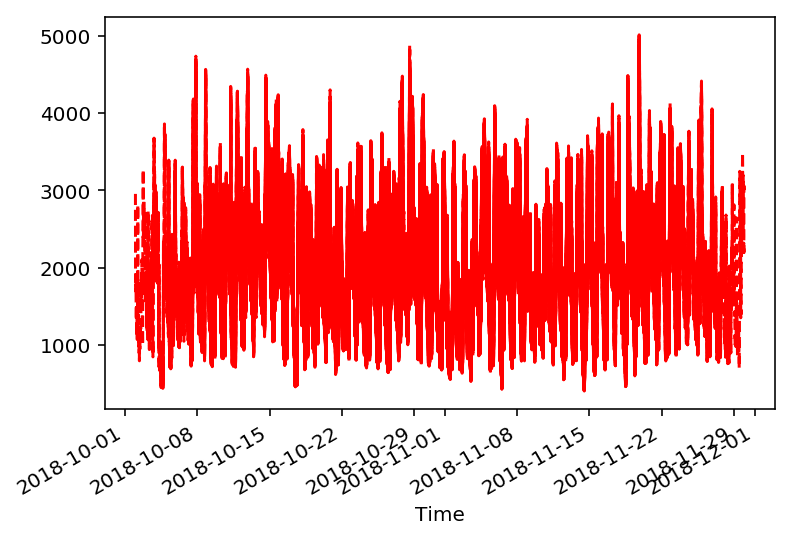

In [14]:
datelist=[]
for i in range(1,31):
    datelist.append('2018_11_'+str(i).zfill(2))
conlist=[]
for i in datelist:
    conlist.append(predictcon(i))

In [20]:
conlist

[[1821.2472871203686,
  1808.071467665313,
  1808.1661035585032,
  1684.0304300552914,
  1645.053792984975,
  1523.3588324998923,
  1590.3125320644388,
  1547.4330880289963,
  1452.81358628162,
  1444.9404240884385,
  1373.4355558139544,
  1409.9691869252845,
  1432.2847652885118,
  1457.5661705465304,
  1336.791947277037,
  1411.1399069159572,
  1408.3231308410989,
  1296.079560570633,
  1397.0916157519587,
  1715.4541697086534,
  1844.369057036707,
  2481.6047170642746,
  1677.3435127167108,
  1258.4902090167868,
  1253.7677085330627,
  1931.4882729220888,
  1164.6023224232697,
  1108.9908110494237,
  1041.9870012079737,
  1190.6260579420812,
  1154.448753393948,
  1200.7454226047862,
  1087.3205553524133,
  1058.1540376984285,
  1068.6897551696206,
  1185.705172046789,
  1106.8654083667811,
  1030.5090471537487,
  1153.400947347055,
  1170.326269539615,
  1159.8729993307022,
  1285.4865279519488,
  1167.2389831827652,
  1142.8577900518037,
  1124.7069463634127,
  1190.3671513410334,

## Run from below

##  Find day that have exact peak load from forecast 1 month

In [19]:
realconlist=[]
for i in datelist:
    realconlist.append(clean1('Energy_Balance_'+i).Consumption)
realconlist

[Time
 2018-11-01 00:15:00    1615
 2018-11-01 00:30:00    1934
 2018-11-01 00:45:00    1655
 2018-11-01 01:00:00    1512
 2018-11-01 01:15:00    1871
 2018-11-01 01:30:00    1563
 2018-11-01 01:45:00    1522
 2018-11-01 02:00:00    1293
 2018-11-01 02:15:00    1685
 2018-11-01 02:30:00    1480
 2018-11-01 02:45:00    1494
 2018-11-01 03:00:00    1402
 2018-11-01 03:15:00    1368
 2018-11-01 03:30:00    1388
 2018-11-01 03:45:00     914
 2018-11-01 04:00:00     811
 2018-11-01 04:15:00    1302
 2018-11-01 04:30:00    1225
 2018-11-01 04:45:00    1050
 2018-11-01 05:00:00    2777
 2018-11-01 05:15:00    1437
 2018-11-01 05:30:00    3332
 2018-11-01 05:45:00    1082
 2018-11-01 06:00:00     775
 2018-11-01 06:15:00     829
 2018-11-01 06:30:00    1587
 2018-11-01 06:45:00     721
 2018-11-01 07:00:00     716
 2018-11-01 07:15:00     898
 2018-11-01 07:30:00     854
 2018-11-01 07:45:00     870
 2018-11-01 08:00:00    1111
 2018-11-01 08:15:00     895
 2018-11-01 08:30:00     935
 2018-11

In [28]:
realconlist[0]

Time
2018-11-01 00:15:00    1615
2018-11-01 00:30:00    1934
2018-11-01 00:45:00    1655
2018-11-01 01:00:00    1512
2018-11-01 01:15:00    1871
2018-11-01 01:30:00    1563
2018-11-01 01:45:00    1522
2018-11-01 02:00:00    1293
2018-11-01 02:15:00    1685
2018-11-01 02:30:00    1480
2018-11-01 02:45:00    1494
2018-11-01 03:00:00    1402
2018-11-01 03:15:00    1368
2018-11-01 03:30:00    1388
2018-11-01 03:45:00     914
2018-11-01 04:00:00     811
2018-11-01 04:15:00    1302
2018-11-01 04:30:00    1225
2018-11-01 04:45:00    1050
2018-11-01 05:00:00    2777
2018-11-01 05:15:00    1437
2018-11-01 05:30:00    3332
2018-11-01 05:45:00    1082
2018-11-01 06:00:00     775
2018-11-01 06:15:00     829
2018-11-01 06:30:00    1587
2018-11-01 06:45:00     721
2018-11-01 07:00:00     716
2018-11-01 07:15:00     898
2018-11-01 07:30:00     854
2018-11-01 07:45:00     870
2018-11-01 08:00:00    1111
2018-11-01 08:15:00     895
2018-11-01 08:30:00     935
2018-11-01 08:45:00     725
2018-11-01 09:0

In [49]:
dayexactpeak=[]
for i in range(30):
    compare=pd.DataFrame(index=realconlist[i].index)
    compare['Real']=realconlist[i]
    compare['Predict']=conlist[i]
    if str(compare.nlargest(1,columns='Real').index)==str(compare.nlargest(1,columns='Predict').index):
        dayexactpeak.append(i+1)
dayexactpeak

[12, 22]

50281.017064087704
38235.96408869861


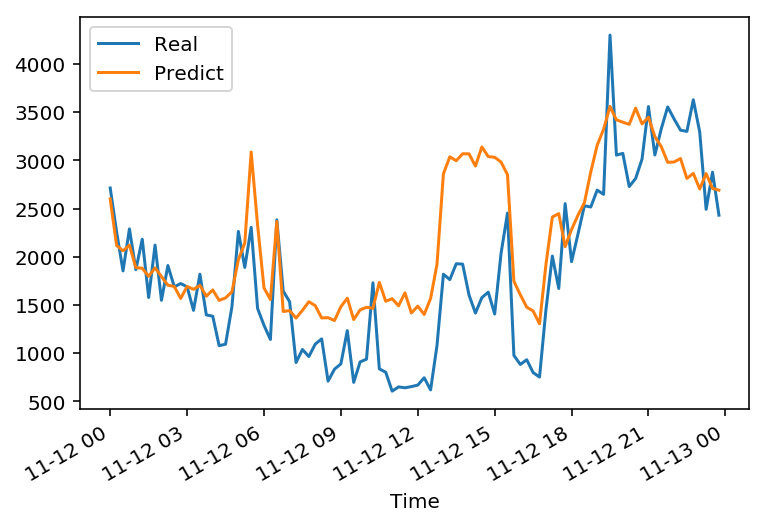

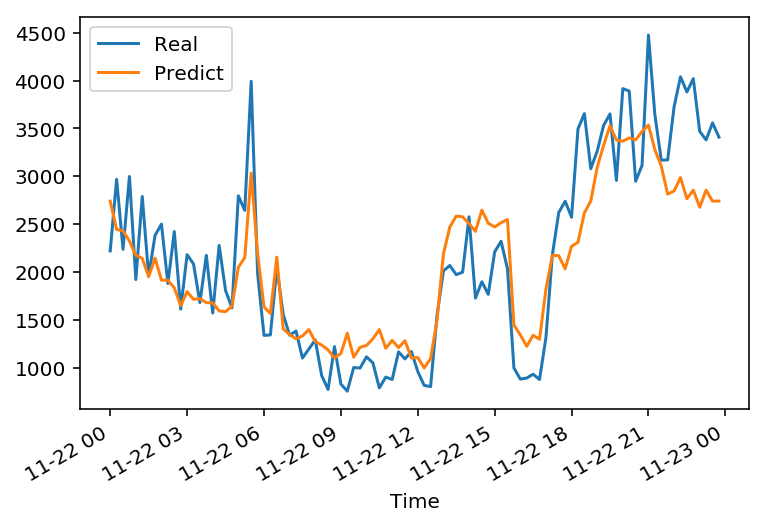

In [55]:
for i in range(1):#dayexactpeak:
    i=12-1
    compare=pd.DataFrame(index=realconlist[i].index)
    compare['Real']=realconlist[i]
    compare['Predict']=conlist[i]
    compare.plot(kind='line')
    print(abs(compare['Real']-compare['Predict']).sum())
for i in range(1):#dayexactpeak:
    i=22-1
    compare=pd.DataFrame(index=realconlist[i].index)
    compare['Real']=realconlist[i]
    compare['Predict']=conlist[i]
    compare.plot(kind='line')
    print(abs(compare['Real']-compare['Predict']).sum())

## Choose 22/11/2018

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-10-01.json (47, 15)
2018-10-02.json (47, 14)
2018-10-03.json (47, 14)
2018-10-04.json (47, 15)
2018-10-05.json (47, 15)
2018-10-06.json (47, 15)
2018-10-07.json (47, 15)
2018-10-08.json (47, 15)
2018-10-09.json (47, 15)
2018-10-10.json (47, 15)
2018-10-11.json (47, 15)
2018-10-12.json (47, 15)
2018-10-13.json (47, 14)
2018-10-14.json (47, 15)
2018-10-15.json (47, 15)
2018-10-16.json (47, 15)
2018-10-17.json (47, 14)
2018-10-18.json (47, 14)
2018-10-19.json (47, 15)
2018-10-20.json (47, 15)
2018-10-21.json (47, 15)
2018-10-22.json (47, 15)
2018-10-23.json (47, 15)
2018-10-24.json (47, 14)
2018-10-25.json (47, 15)
2018-10-26.json (47, 15)
2018-10-27.json (47, 15)
2018-10-28.json (47, 15)
2018-10-29.json (47, 15)
2018-10-30.json (47, 15)
2018-10-31.json (47, 15)
2018-11-01.json (47, 15)
2018-11-02.json (47, 13)
2018-11-03.json (47, 15)
2018-11-04.json (47, 14)
2018-11-05.json (47, 14)
2018-11-06.json (47, 15)
2018-11-07.json (47, 14)
2018-11-08.json (47, 15)
2018-11-09.json (47, 14)


,Generation,Consumption,Contactor
Time,,,
2018-12-23 00:15:00,0,1840,0
2018-12-23 00:30:00,0,1658,0
2018-12-23 00:45:00,0,1806,0
2018-12-23 01:00:00,0,1672,0
2018-12-23 01:15:00,0,1509,0
2018-12-23 01:30:00,0,1429,0
2018-12-23 01:45:00,0,1806,0
2018-12-23 02:00:00,0,1675,0
2018-12-23 02:15:00,0,1429,0


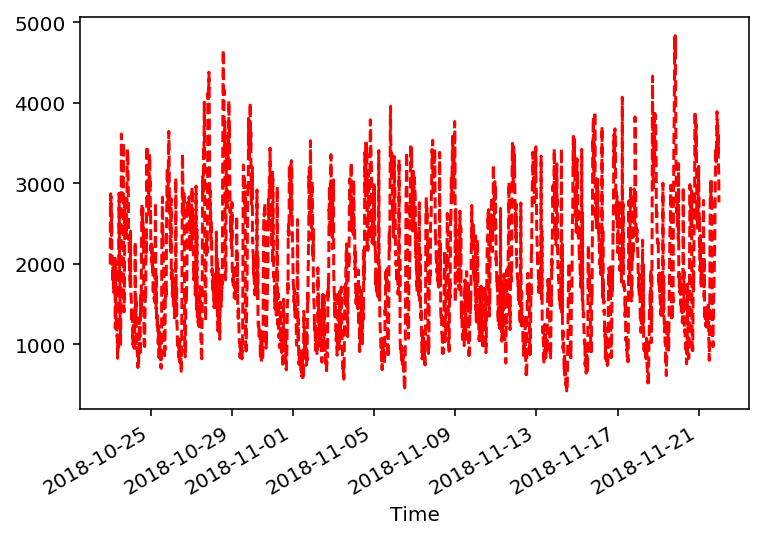

In [58]:
rawdata=predict('2018_11_22')
rawdata=peakloadmode(rawdata,100)
realdata=clean1('Energy_Balance_'+predict_date)
predict_day=int(predict_date[8:])
predict_month=int(predict_date[5:7])
predict_year=int(predict_date[0:4])
pmb=predict_month-1
if predict_day>1:
    db=(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(31).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(30).zfill(2))
    else:
        if predict_year%4==0:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(29).zfill(2))
        else:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(38).zfill(2))    
dayb=clean1('Energy_Balance_'+db)
for i in range(realdata.shape[0]):
    if realdata.iloc[i,1]==0:
        realdata.iloc[i,0]=dayb.iloc[i,0]
        realdata.iloc[i,1]=dayb.iloc[i,1]
        
        
burden=0
totalcharge=rawdata.Charge.sum()+burden
realdata['Contactor']=rawdata['Contactor']
realdata

In [59]:
batt=totalcharge
storage=[]
charge=[]
discharge=[]
for i in range(96):
    if realdata.iloc[i,2]==1:
        if realdata.iloc[i,0]>realdata.iloc[i,1]:
            batt+=realdata.iloc[i,0]-realdata.iloc[i,1]
            storage.append(batt)
            charge.append(realdata.iloc[i,0]-realdata.iloc[i,1])
            discharge.append(0)
        elif realdata.iloc[i,0]<=realdata.iloc[i,1]:
            if batt>=realdata.iloc[i,1]-realdata.iloc[i,0]:
                batt-=realdata.iloc[i,1]-realdata.iloc[i,0]
                storage.append(batt)
                charge.append(0)
                discharge.append(realdata.iloc[i,1]-realdata.iloc[i,0])
            elif batt>=0:
                charge.append(0)
                discharge.append(batt)
                batt=0
                storage.append(batt)
    else:
        storage.append(batt)
        charge.append(0)
        discharge.append(0)
Battcompare=batt-totalcharge
print(Battcompare)
realdata['Storage']=storage
realdata['Charge']=charge
realdata['Discharge']=discharge
realdata['Consumption_afterDischarge']=realdata['Consumption']-realdata['Generation']-realdata['Discharge']
for i in range(96):
    if realdata.iloc[i,6]<0:
        realdata.iloc[i,6]=0

-2487.999999999999


In [60]:
realdata

,Generation,Consumption,Contactor,Storage,Charge,Discharge,Consumption_afterDischarge
Time,,,,,,,
2018-12-23 00:15:00,0,1840,0,5219.705458,0,0,1840
2018-12-23 00:30:00,0,1658,0,5219.705458,0,0,1658
2018-12-23 00:45:00,0,1806,0,5219.705458,0,0,1806
2018-12-23 01:00:00,0,1672,0,5219.705458,0,0,1672
2018-12-23 01:15:00,0,1509,0,5219.705458,0,0,1509
2018-12-23 01:30:00,0,1429,0,5219.705458,0,0,1429
2018-12-23 01:45:00,0,1806,0,5219.705458,0,0,1806
2018-12-23 02:00:00,0,1675,0,5219.705458,0,0,1675
2018-12-23 02:15:00,0,1429,0,5219.705458,0,0,1429


Text(0, 0.5, 'Watt(W)')

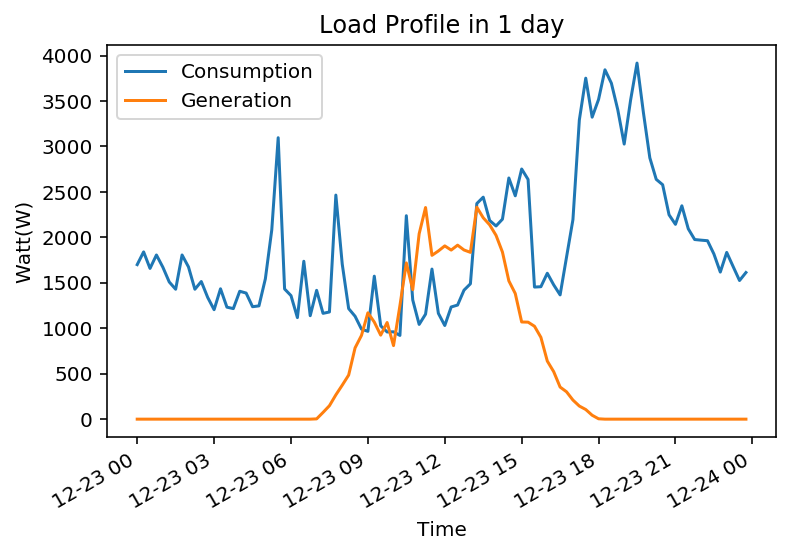

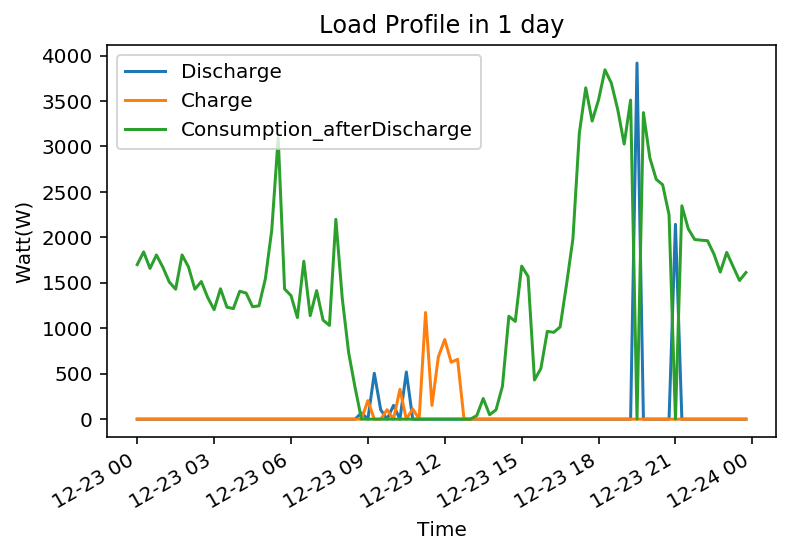

In [61]:
realdata[['Consumption','Generation']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')
realdata[['Discharge','Charge','Consumption_afterDischarge']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')

In [64]:
ideal=peakloadmode(clean1('Energy_Balance_'+predict_date),100)
ideal

,Generation,Consumption,Charge,Consumption_afterPV,Discharge,Contactor
Time,,,,,,
2018-12-23 00:15:00,0,1840,0,1840,0,0
2018-12-23 00:30:00,0,1658,0,1658,0,0
2018-12-23 00:45:00,0,1806,0,1806,0,0
2018-12-23 01:00:00,0,1672,0,1672,0,0
2018-12-23 01:15:00,0,1509,0,1509,0,0
2018-12-23 01:30:00,0,1429,0,1429,0,0
2018-12-23 01:45:00,0,1806,0,1806,0,0
2018-12-23 02:00:00,0,1675,0,1675,0,0
2018-12-23 02:15:00,0,1429,0,1429,0,0


Text(0, 0.5, 'Watt(W)')

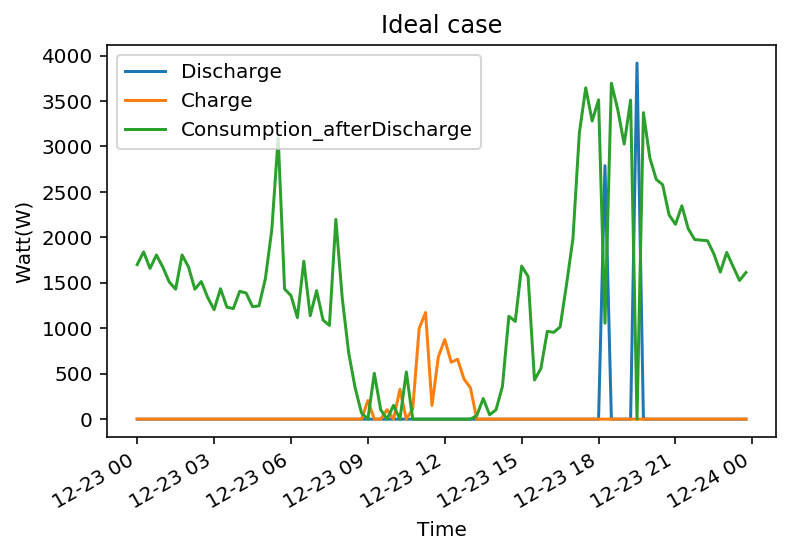

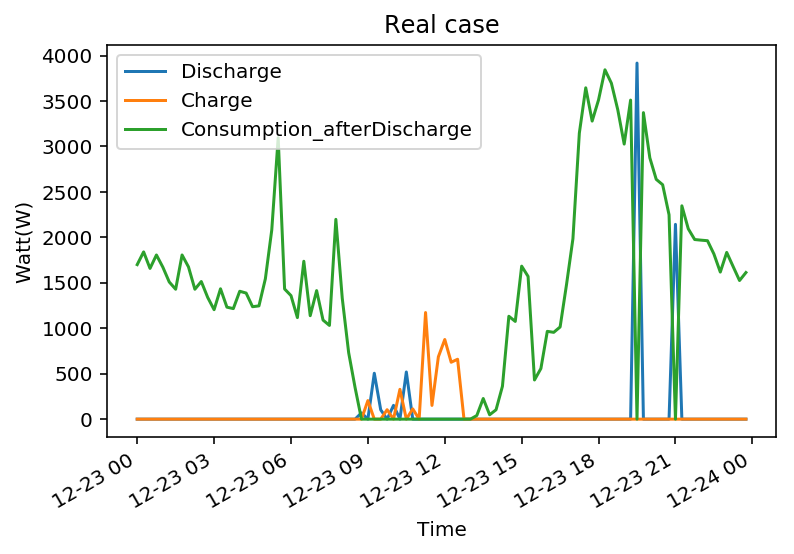

In [66]:
ideal.rename(columns={'Consumption_afterPV':'Consumption_afterDischarge'},inplace=True)
ideal[['Discharge','Charge','Consumption_afterDischarge']].plot(kind='line',title='Ideal case').set_ylabel('Watt(W)')
realdata[['Discharge','Charge','Consumption_afterDischarge']].plot(kind='line',title='Real case').set_ylabel('Watt(W)')

In [78]:
def clean2(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  'and i!= 'Battery charging / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.rename(columns={'Battery discharging / Mean values [W] ':'Discharge'},inplace=True)
    rawdata.rename(columns={'Battery charging / Mean values [W]  ':'Charge'},inplace=True)    
    return rawdata

In [85]:
Realwithnoalgo=clean2('Energy_Balance_'+predict_date)
Realwithnoalgo['Consumption_afterDischarge']=Realwithnoalgo['Consumption']-Realwithnoalgo['Generation']-Realwithnoalgo['Discharge']
for i in range(96):
    if Realwithnoalgo.iloc[i,4] <0:
        Realwithnoalgo.iloc[i,4]=0
Realwithnoalgo

,Discharge,Charge,Generation,Consumption,Consumption_afterDischarge
Time,,,,,
2018-12-23 00:15:00,1,0,0,1840,1839
2018-12-23 00:30:00,0,0,0,1658,1658
2018-12-23 00:45:00,1,0,0,1806,1805
2018-12-23 01:00:00,2,0,0,1672,1670
2018-12-23 01:15:00,0,0,0,1509,1509
2018-12-23 01:30:00,0,0,0,1429,1429
2018-12-23 01:45:00,0,0,0,1806,1806
2018-12-23 02:00:00,2,0,0,1675,1673
2018-12-23 02:15:00,0,1,0,1429,1429


In [90]:
realdata['Consumption_afterDischarge'].nlargest(1)[0]-Realwithnoalgo['Consumption_afterDischarge'].nlargest(1)[0]


-73